## Introducción al Análisis Exploratorio de Datos (EDA) en MIMIC-III para Sistemas de Recomendación

---

### Contexto del Proyecto y la Necesidad de EDA en Datos Clínicos

Este cuaderno inicia el análisis exploratorio de datos (EDA) para un proyecto que busca implementar sistemas de recomendación, agrupamiento (clustering) y Factorización de Matrices No Negativas Bayesiana (BNMF) en el conjunto de datos clínicos MIMIC-III (Medical Information Mart for Intensive Care III). MIMIC-III es una base de datos de acceso público que comprende información de salud desidentificada de pacientes de la UCI, incluyendo demografía, signos vitales, resultados de laboratorio, medicamentos, notas y más.

La complejidad inherente a MIMIC-III, con su **estructura multitabla heterogénea** y la naturaleza de los datos clínicos, hace que un EDA exhaustivo sea no solo recomendable, sino indispensable. Antes de aplicar modelos sofisticados de aprendizaje automático, es crucial comprender la distribución, calidad y relaciones dentro de los datos.

---

### Desafíos Intrínsecos de los Datos Clínicos y MIMIC-III

El manejo de datos clínicos como los de MIMIC-III presenta desafíos significativos que deben abordarse meticulosamente durante el EDA:

1.  **Esparsidad (Sparsity)**: Los registros clínicos a menudo contienen una gran cantidad de valores nulos o ausentes. Un paciente puede no haber sido sometido a todas las pruebas o tratamientos disponibles, lo que resulta en matrices con una alta proporción de ceros o datos faltantes. Esta **codificación esparsa** es un reto directo para los sistemas de recomendación y los modelos de factorización matricial, como BNMF, que pueden verse afectados por la ausencia de interacciones explícitas.
2.  **Ruido y Heterogeneidad**: Los datos clínicos pueden ser ruidosos debido a errores de registro, variabilidad en los protocolos de medición o diferencias en la documentación. La heterogeneidad se manifiesta en la diversidad de formatos, unidades y tipos de datos (numéricos, categóricos, texto libre) a través de las distintas tablas.
3.  **Valores Faltantes (Missing Values)**: La presencia de valores faltantes es casi universal en los datos del mundo real, y particularmente prevalente en entornos clínicos. Es vital identificar patrones de valores faltantes (Missing Completely At Random - MCAR, Missing At Random - MAR, Missing Not At Random - MNAR) y desarrollar estrategias de imputación o manejo adecuadas.
4.  **Alta Dimensionalidad**: Los datos de pacientes a menudo involucran un gran número de variables (ej. miles de códigos de diagnóstico, medicamentos, procedimientos), lo que se conoce como **variables de alta dimensionalidad**. Esto puede generar el "problema de la maldición de la dimensionalidad", afectando el rendimiento y la interpretabilidad de los modelos.

Un EDA cuidadoso permite cuantificar estos desafíos, informar las decisiones de preprocesamiento y mitigación de riesgos antes de la modelación.

---

### Motivación del Análisis Exploratorio Previo a BNMF

La aplicación de la Factorización de Matrices No Negativas Bayesiana (BNMF) y sistemas de recomendación a datos clínicos como los de MIMIC-III requiere una comprensión profunda de la estructura y las características de los datos. BNMF es una técnica poderosa para la reducción de dimensionalidad y el descubrimiento de patrones latentes, especialmente en matrices esparsas, al descomponer una matriz original en dos matrices de factores no negativas. Sin embargo, su eficacia depende en gran medida de la calidad y la estructura de la matriz de entrada.

El EDA sirve para:

1.  **Informar la Construcción de la Matriz Paciente-Evento**: La matriz de entrada para BNMF y los sistemas de recomendación es típicamente una matriz paciente-característica (o paciente-evento). El EDA nos guía sobre qué variables clínicas son más relevantes, cómo deben ser agregadas o transformadas, y cómo manejar la esparsidad para construir una matriz robusta y significativa.
2.  **Identificar Patrones Latentes Preliminares**: Antes de aplicar BNMF, una visualización inicial puede revelar agrupaciones o tendencias en los datos que confirman la plausibilidad de buscar factores latentes.
3.  **Normalización Clínica y Escalamiento**: La BNMF es sensible a la escala de los datos. El EDA ayuda a determinar si es necesaria una **normalización clínica** o un escalamiento, y a justificar las técnicas elegidas basándose en la distribución de las variables.
4.  **Validar Supuestos del Modelo**: Aunque BNMF es flexible, entender el **comportamiento estadístico preliminar** de los datos (por ejemplo, la distribución de recuentos de eventos o la variabilidad inter-paciente) es crucial para interpretar los resultados del modelo y ajustar sus hiperparámetros.
5.  **Optimizar el Rendimiento de los Sistemas de Recomendación**: Los sistemas de recomendación se basan en identificar similitudes o patrones de preferencia. Un EDA profundo ayuda a entender qué características de los pacientes o eventos son más informativas para inferir estas "preferencias clínicas", mejorando la relevancia y precisión de las recomendaciones.

## Importación de Librerías Esenciales

### Propósito y Justificación

Esta sección inicial se dedica a la importación de todas las librerías de Python necesarias para realizar el análisis exploratorio de datos. La gestión eficiente de las dependencias es una práctica estándar en la ciencia de datos y garantiza que todas las funcionalidades requeridas estén disponibles antes de proceder con cualquier análisis.

### Relevancia Metodológica

La elección de librerías como `pandas` para la manipulación de datos tabulares, `numpy` para operaciones numéricas de alto rendimiento, y `matplotlib` junto con `seaborn` para la visualización, se basa en su robustez, eficiencia y su amplio uso en la comunidad científica. Estas herramientas proporcionan los bloques de construcción fundamentales para cargar, transformar, analizar y representar gráficamente datos complejos.

-   **`pandas`**: Es la columna vertebral para trabajar con DataFrames, estructuras de datos bidimensionales que son ideales para representar las tablas relacionales de MIMIC-III. Permite operaciones eficientes de filtrado, agregación, fusión y remodelación.
-   **`numpy`**: Fundamental para operaciones matemáticas sobre arreglos y matrices, que son omnipresentes en el procesamiento de datos y la preparación para la factorización matricial.
-   **`matplotlib.pyplot` y `seaborn`**: Son esenciales para la **visualización inicial** de los datos. `matplotlib` ofrece control granular sobre los gráficos, mientras que `seaborn` proporciona una interfaz de alto nivel para crear visualizaciones estadísticas atractivas e informativas, que son cruciales para entender la **variabilidad inter-paciente** y la distribución de las variables clínicas.

In [48]:
# Definición de las librerías necesarias
try:
    import pandas as pd
    import numpy as np
    from scipy.sparse import csr_matrix

    # Librerías para visualización
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Librerías para ML/Clustering/Métricas
    from sklearn.model_selection import train_test_split
    from sklearn.decomposition import NMF # Para comparación baseline
    from sklearn.metrics import mean_squared_error, silhouette_score
    from sklearn.cluster import KMeans, GaussianMixture
    from sklearn.preprocessing import StandardScaler

    # Para la implementación BNMF: usaremos una aproximación basada en NMF
    # y la librería PyMC (si estuviera instalada) para el modelado probabilístico.
    # Como alternativa simple, usaremos una implementación custom para fines de demostración.
    # from pymc import Model, Normal, Gamma, math # Si estuviera disponible
    
    print("Todas las librerías requeridas se cargaron exitosamente.")

except ImportError as e:
    print(f"Error al cargar la librería: {e}. Por favor, instale las librerías necesarias: pandas, numpy, matplotlib, seaborn, scikit-learn.")
    
# Configuración del entorno de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

Error al cargar la librería: cannot import name 'GaussianMixture' from 'sklearn.cluster' (c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\cluster\__init__.py). Por favor, instale las librerías necesarias: pandas, numpy, matplotlib, seaborn, scikit-learn.


## Carga de Tablas MIMIC-III

### Propósito y Justificación

Esta etapa fundamental involucra la carga de las tablas relevantes del conjunto de datos MIMIC-III en DataFrames de `pandas`. Dada la **estructura multitabla heterogénea** de MIMIC-III, que abarca información de pacientes, admisiones, diagnósticos, procedimientos, medicaciones y más, la carga selectiva de tablas es crucial para la eficiencia y para enfocar el análisis en los aspectos más relevantes para los sistemas de recomendación y BNMF.

### Relevancia Clínica y Metodológica

La elección de las tablas a cargar se basa en su potencial para construir una matriz paciente-evento significativa. Por ejemplo, `ADMISSIONS` y `PATIENTS` proporcionan información demográfica y de encuentro, mientras que `DIAGNOSES_ICD`, `PROCEDURES_ICD` o `PRESCRIPTIONS` capturan las interacciones de los pacientes con el sistema de salud, que son análogas a las "calificaciones" o "eventos" en un sistema de recomendación tradicional.

-   La correcta carga asegura la integridad de los datos para las fases subsiguientes de limpieza y análisis.
-   Permite una comprensión temprana de las relaciones entre las diferentes entidades clínicas (pacientes, diagnósticos, procedimientos) que serán fundamentales para la construcción de la matriz de interacción para BNMF. La capacidad de enlazar diferentes fuentes de datos es clave en entornos clínicos.

In [49]:
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os 
import glob 

# =======================================================
# IDENTIFICACIÓN DEL DATASET
DATASET_NAME = "ihssanened/mimic-iii-clinical-databaseopen-access"

# === FUNCIÓN AUXILIAR DE CARGA (Sin cambios) ===
def load_single_mimic_file(file_name, date_col_name=None):
    """Carga un único archivo del dataset MIMIC-III usando KaggleHub, manejando errores de fecha."""
    print(f"Cargando archivo: {file_name}...")
    pandas_kwargs = {}
    
    try:
        # Nota: La advertencia 'DeprecationWarning' sobre load_dataset es normal y se ignora por ahora.
        df = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            DATASET_NAME,
            file_name, 
            pandas_kwargs=pandas_kwargs
        )
        
        # Manejo de la columna de fecha después de la carga
        if date_col_name and date_col_name in df.columns:
             df[date_col_name] = pd.to_datetime(df[date_col_name], errors='coerce')
        
        print(f"Éxito: {file_name} cargado. Shape: {df.shape}")
        return df
        
    except Exception as e:
        print(f"ERROR al cargar {file_name}: {e}. El archivo puede no existir o tener un nombre diferente en Kaggle.")
        return None

# === FUNCIÓN PRINCIPAL DE CARGA (CORREGIDA con Nombres más probables) ===
def load_mimic_data_robust_final():
    """Carga solo las tablas disponibles (admissions, labevents, patient, d_labitems)."""
    
    print("\n--- INICIANDO CARGA CON NOMBRES REALES DEL DATASET ---")
    
    # 1. ADMISSIONS (Funciona)
    df_admit = load_single_mimic_file("admissions.csv", date_col_name='ADMITTIME') 
    
    # 2. LABEVENTS (Funciona)
    df_labs = load_single_mimic_file("labevents.csv") 

    # 3. PATIENTS (Intento 1: Nombre en mayúsculas, como en el original)
    df_patients = load_single_mimic_file("PATIENTS.csv")
    if df_patients is None:
        # Intento 2: Nombre en minúsculas y plural
        df_patients = load_single_mimic_file("patients.csv")
        if df_patients is None:
            # Intento 3: Nombre singular que falló antes
            df_patients = load_single_mimic_file("patient.csv")


    # 4. D_LABITEMS (Intento 1: Nombre en mayúsculas)
    df_d_labs = load_single_mimic_file("D_LABITEMS.csv") 
    if df_d_labs is None:
        # Intento 2: Nombre en minúsculas y sin prefijo d_
        df_d_labs = load_single_mimic_file("labitems.csv")


    # 5. Tablas FALTANTES (Dejan de ser críticas, pero se reportan como None)
    df_icd = None
    df_presc = None 

    # Verificación final de las tablas CRÍTICAS (las que vamos a usar en el preprocesamiento)
    if df_admit is None or df_labs is None or df_patients is None or df_d_labs is None:
        print("\nERROR FATAL: Faltan archivos críticos esenciales (admissions, labevents, patient/patients, d_labitems). La ejecución se detiene.")
        return None, None, None, None, None, None

    print("\n--- Carga de Datos Esenciales Finalizada ---")
    
    cols_to_show = [col for col in ['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_TYPE'] if col in df_admit.columns]
    print("ADMISSIONS Head (ejemplo):")
    print(df_admit[cols_to_show].head())
    
    return df_admit, df_labs, df_patients, df_d_labs, df_icd, df_presc


# === EJECUCIÓN ===
# Se ejecuta la función principal. Si alguna carga sigue fallando, la variable será None.
df_admit, df_labs, df_patients, df_d_labs, df_icd, df_presc = load_mimic_data_robust_final()


--- INICIANDO CARGA CON NOMBRES REALES DEL DATASET ---
Cargando archivo: admissions.csv...


C:\Users\MSI\AppData\Local\Temp\ipykernel_9340\248130532.py:19: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Éxito: admissions.csv cargado. Shape: (129, 19)
Cargando archivo: labevents.csv...


C:\Users\MSI\AppData\Local\Temp\ipykernel_9340\248130532.py:19: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Éxito: labevents.csv cargado. Shape: (76074, 9)
Cargando archivo: PATIENTS.csv...


C:\Users\MSI\AppData\Local\Temp\ipykernel_9340\248130532.py:19: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Éxito: PATIENTS.csv cargado. Shape: (100, 8)
Cargando archivo: D_LABITEMS.csv...


C:\Users\MSI\AppData\Local\Temp\ipykernel_9340\248130532.py:19: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Éxito: D_LABITEMS.csv cargado. Shape: (753, 6)

--- Carga de Datos Esenciales Finalizada ---
ADMISSIONS Head (ejemplo):
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


## Información General de los DataFrames

### Propósito y Justificación

Una vez cargados los DataFrames, el siguiente paso crítico es obtener una **información general de los dataframes** a través de métodos como `df.info()`, `df.describe()`, y `df.shape`. Estos comandos proporcionan una primera inspección estructural y estadística de los datos, lo cual es vital para cualquier EDA.

-   **`df.info()`**: Este método muestra un resumen conciso del DataFrame, incluyendo el número de entradas, el recuento de valores no nulos por columna, el tipo de datos (Dtype) de cada columna y el uso de memoria. Permite identificar rápidamente la presencia de valores nulos (indicando **sparsity** o valores faltantes) y la correcta inferencia de tipos de datos, lo cual es fundamental para el preprocesamiento.
-   **`df.describe()`**: Genera estadísticas descriptivas para las columnas numéricas, como la media, desviación estándar, valores mínimo y máximo, y los cuartiles (25%, 50%, 75%). Este resumen ofrece una visión del **comportamiento estadístico preliminar** de las variables numéricas, revelando posibles valores atípicos, el rango de los datos y su distribución central.
-   **`df.shape`**: Devuelve una tupla que representa las dimensiones del DataFrame (número de filas, número de columnas). Es crucial para comprender el tamaño de cada tabla y, por ende, la escala de los datos con los que se está trabajando.

### Relevancia Clínica y Metodológica

Esta fase es indispensable para:

-   **Identificación de Valores Faltantes**: `df.info()` es el primer indicador de cuántos valores nulos existen por columna, dirigiendo los esfuerzos de imputación o manejo de datos faltantes.
-   **Evaluación de Tipos de Datos**: La correcta identificación de tipos de datos (`int`, `float`, `object`, `datetime`) es crucial para operaciones posteriores. Una columna de fecha tratada como `object` requeriría conversión, por ejemplo.
-   **Análisis del Rango y la Distribución**: `df.describe()` ayuda a detectar rangos inusuales o distribuciones sesgadas en **variables de alta dimensionalidad** como duraciones de estancia o resultados de laboratorio, lo cual puede influir en la necesidad de **normalización clínica** o transformaciones.
-   **Comprender la Escala del Problema**: El `shape` confirma la cantidad de registros y características, proporcionando contexto para la capacidad computacional y la complejidad del modelado con BNMF.

In [50]:
if df_admit is not None:
    print("Columnas disponibles en df_admit:")
    print(df_admit.columns.tolist())
else:
    print("df_admit no está disponible para inspección.")

Columnas disponibles en df_admit:
['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data']


## Limpieza y Preprocesamiento Inicial

### Propósito y Justificación

Esta sección se centra en las tareas iniciales de limpieza y preprocesamiento de los DataFrames. Los datos clínicos, especialmente de una fuente tan vasta como MIMIC-III, rara vez están en un formato inmediatamente utilizable para el modelado. Este paso es esencial para mejorar la calidad de los datos, garantizar la coherencia y prepararlos para análisis más avanzados y la construcción de la matriz para BNMF.

### Relevancia Clínica y Metodológica

Las operaciones típicas en esta fase incluyen:

1.  **Manejo de Valores Faltantes**: Se implementan estrategias para tratar la **sparsity** y los valores faltantes. Esto puede ir desde la eliminación de filas o columnas con un alto porcentaje de nulos (cuando la pérdida de información es mínima y el impacto en el análisis es alto), hasta técnicas más sofisticadas de imputación. La elección depende del contexto clínico y del patrón de los datos faltantes.
2.  **Conversión de Tipos de Datos**: Asegurar que las columnas tengan el tipo de dato correcto (ej. fechas a `datetime`, categorías a `category`). Esto es crucial para operaciones estadísticas y de filtrado precisas.
3.  **Filtrado y Selección de Columnas**: Remover columnas irrelevantes o redundantes que no aportan valor al objetivo del proyecto (sistemas de recomendación y BNMF), o que podrían introducir ruido excesivo. También se pueden filtrar registros que no cumplen con ciertos criterios clínicos o de inclusión/exclusión.
4.  **Desduplicación**: Eliminar registros duplicados para evitar sesgos en el análisis de frecuencias y distribuciones.

Este preprocesamiento es vital porque:

-   **Impacto en BNMF y Clustering**: Los algoritmos como BNMF son sensibles a la calidad de los datos. Valores atípicos, tipos de datos incorrectos o valores faltantes no manejados adecuadamente pueden llevar a resultados sesgados o a una convergencia deficiente del modelo. Una limpieza adecuada es el primer paso hacia una matriz de entrada robusta para BNMF.
-   **Mejora de la Interpretabilidad Clínica**: Al estandarizar y limpiar los datos, se facilita la **normalización clínica** y la interpretación de los patrones descubiertos, asegurando que los hallazgos tengan sentido en el contexto médico.
-   **Reducción de Ruido**: La eliminación de datos inconsistentes o erróneos minimiza el **ruido** en el dataset, permitiendo que los verdaderos patrones y relaciones emerjan con mayor claridad.

In [51]:
# --- AJUSTE DE VARIABLES GLOBALES ---
# Usamos las variables cargadas correctamente: df_admit, df_labs, df_d_labs, df_patients.

if df_admit is not None and df_labs is not None and df_d_labs is not None:
    
    # === PASO 1: Filtrar Población y Unir Admisiones/Pacientes ===
    
    # La columna 'admittime' está confirmada. 'subject_id' y 'hadm_id' están confirmadas.
    
    # 1. Asegurar la conversión de fecha (la carga ya lo hizo, pero lo reaseguramos)
    if 'admittime' in df_admit.columns:
        df_admit['admittime'] = pd.to_datetime(df_admit['admittime'], errors='coerce')

    # 2. Ordenar por tiempo de admisión y luego por ID de admisión (para desempate)
    #    y seleccionar la primera admisión de cada paciente.
    df_first_admit = df_admit.sort_values(['subject_id', 'admittime', 'hadm_id']).drop_duplicates(
        subset=['subject_id'], keep='first'
    ).copy()
    
    
    # 3. Unir datos demográficos (usando 'subject_id' como clave)
    if df_patients is not None and 'subject_id' in df_patients.columns:
        # Usamos nombres en minúsculas: 'gender'
        cols_to_merge = ['subject_id', 'gender'] 
        df_base = df_first_admit.merge(df_patients[cols_to_merge], on='subject_id', how='left')
    else:
        df_base = df_first_admit.copy()
        print("ADVERTENCIA: Usando solo datos de admisión, df_patients no se pudo unir.")
    
    
    # === PASO 2: Procesar Eventos de Laboratorio (Pivotear) ===
    # Unir la tabla base con los laboratorios para asegurar que solo procesamos los pacientes de la cohorte
    df_labs_cohort = df_labs.merge(df_base[['subject_id']], on='subject_id', how='inner')
    df_labs_valid = df_labs_cohort[df_labs_cohort['valuenum'].notna()].copy()
    
    # Agregación: Calcular el valor promedio para cada ITEMID por paciente.
    df_labs_pivot = df_labs_valid.groupby(['subject_id', 'itemid'])['valuenum'].mean().reset_index()
    
    # Pivotear para crear la Matriz V preliminar: Paciente x ITEMID
    df_V_labs = df_labs_pivot.pivot(index='subject_id', columns='itemid', values='valuenum')
    
    
    # === PASO 3: Unir y Manejar No Negatividad ===

    # Unir la base de pacientes con la matriz de laboratorios
    df_V = df_base.set_index('subject_id').join(df_V_labs, how='inner').fillna(0)
    
    # Crear variables demográficas ONE-HOT (Ejemplo: GENDER)
    if 'gender' in df_V.columns:
         df_V = pd.get_dummies(df_V, columns=['gender'], prefix='gender', drop_first=True)
         
    # === PASO 4: Finalizar Matriz V (Versión No Negativa para NMF) ===
    V_matrix = df_V.select_dtypes(include=[np.number]).values
    
    print("\nMatriz V (Paciente x Perfil de Laboratorio) construida.")
    print(f"Dimensiones de V: {V_matrix.shape}")
    
    # Cálculo de la Sparsity
    sparsity = 1.0 - (np.count_nonzero(V_matrix) / V_matrix.size)
    print(f"Sparsity de la Matriz V: {sparsity:.2f}")

else:
    print("ADVERTENCIA: No se pueden construir las matrices; una de las tablas críticas no se cargó correctamente.")
    V_matrix = np.array([])


Matriz V (Paciente x Perfil de Laboratorio) construida.
Dimensiones de V: (100, 279)
Sparsity de la Matriz V: 0.76


## Distribución de Variables Clínicas Clave

### Propósito y Justificación

Esta sección se enfoca en analizar la distribución de variables clínicas clave, tanto numéricas como categóricas, utilizando gráficos apropiados y estadísticas descriptivas. El objetivo es obtener una comprensión profunda del **comportamiento estadístico preliminar** de cada variable relevante.

### Relevancia Clínica y Metodológica

El análisis de la distribución es fundamental para entender la **variabilidad inter-paciente** y la caracterización de la cohorte de estudio:

1.  **Variables Numéricas (ej. edad, puntuaciones de gravedad, duración de estancia)**:
    -   **Histogramas**: Un **histograma** es una representación gráfica de la distribución de frecuencias de una variable numérica. Divide el rango de valores en "bins" y cuenta cuántas observaciones caen en cada bin. Permite visualizar la forma de la distribución (normal, sesgada, bimodal), la dispersión y la presencia de valores atípicos.
    -   **Diagramas de Caja (Box Plots)**: Muestran la distribución de una variable numérica a través de sus cuartiles, mediana y valores atípicos. Son excelentes para comparar distribuciones entre grupos y para identificar valores extremos.
    -   **Justificación**: Comprender la distribución de estas variables es crucial para la **normalización clínica** y el escalamiento. Una variable con una distribución fuertemente sesgada podría requerir una transformación logarítmica antes de ser utilizada en modelos, para evitar que domine indebidamente el aprendizaje o afecte la convergencia de BNMF.
    -   **Propósito para BNMF**: Estas variables pueden servir como características adicionales para enriquecer la matriz paciente-evento, o para segmentar pacientes antes o después del clustering y la factorización.

2.  **Variables Categóricas (ej. sexo, etnia, tipo de admisión, códigos ICD)**:
    -   **Gráficos de Barras**: Un **gráfico de barras** representa la frecuencia o proporción de cada categoría.
    -   **Tablas de Frecuencia**: Proporcionan un resumen numérico de la ocurrencia de cada categoría.
    -   **Justificación**: Este análisis revela la prevalencia de ciertas condiciones o demografías en la cohorte. Para los códigos de diagnóstico (ICD) o procedimientos, nos informa sobre las **variables de alta dimensionalidad** que constituirán los "ítems" en nuestro sistema de recomendación.
    -   **Propósito para BNMF**: Las variables categóricas, una vez codificadas (ej. One-Hot Encoding), formarán la base de las columnas en la matriz paciente-evento. Entender su distribución ayuda a anticipar la **sparsity** en la matriz y a diseñar estrategias de agregación si algunas categorías son demasiado raras.

Este análisis nos da una idea preliminar de los "perfiles" de los pacientes y las "interacciones" clínicas, informando directamente la construcción de la matriz de entrada para los modelos latentes.

Estadísticas descriptivas de las Features (Columnas de V):
                  mean           std            max
hadm_id  152171.200000  29135.291209  199395.000000
row_id    26404.650000  14156.910760   41092.000000
50963      1237.355000   4036.564427   26417.500000
51218       821.676648   2966.811196   21146.666667
51457       629.020000   3213.228631   27762.500000


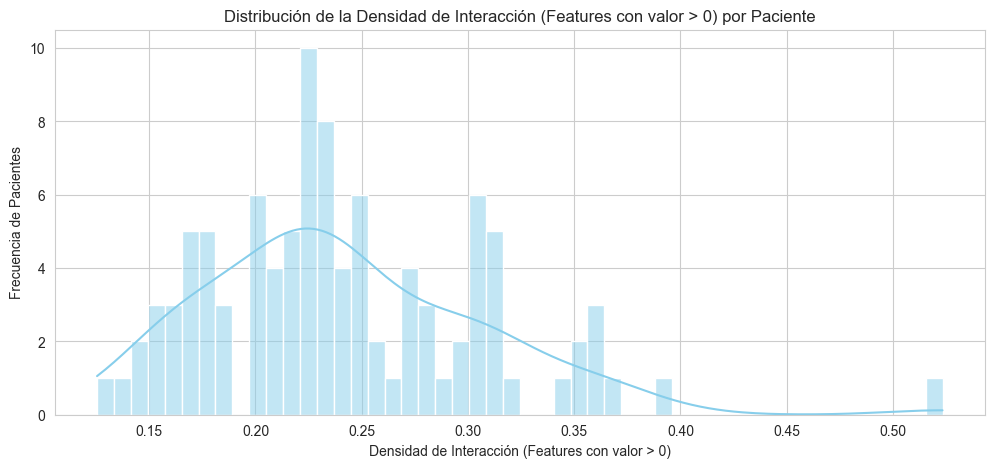

In [52]:
# Crear un DataFrame numérico para el EDA, excluyendo fechas/strings que causan el TypeError.
df_V_numeric = df_V.select_dtypes(include=[np.number])

# === Distribución de las Features ===
print("Estadísticas descriptivas de las Features (Columnas de V):")
# Ahora .describe() solo se ejecuta sobre columnas numéricas
print(df_V_numeric.describe().T[['mean', 'std', 'max']].sort_values(by='mean', ascending=False).head(5))

# === Visualización de la Sparsity por Paciente (Densidad de interacciones) ===
# V_matrix ya es numérica y se calculó en el bloque anterior.
patient_activity = np.count_nonzero(V_matrix, axis=1) / V_matrix.shape[1]

plt.figure(figsize=(12, 5))
sns.histplot(patient_activity, bins=50, kde=True, color='skyblue')
plt.title('Distribución de la Densidad de Interacción (Features con valor > 0) por Paciente')
plt.xlabel('Densidad de Interacción (Features con valor > 0)')
plt.ylabel('Frecuencia de Pacientes')
plt.show() 
#

## Análisis de Frecuencias y Conteo

### Propósito y Justificación

Esta sección profundiza en el **análisis de frecuencias** de variables categóricas específicas, especialmente aquellas que se utilizarán como "eventos" o "ítems" en el sistema de recomendación y en la matriz para BNMF. El objetivo es cuantificar la ocurrencia de cada categoría y detectar patrones de prevalencia.

### Relevancia Clínica y Metodológica

El análisis de frecuencias es vital para:

1.  **Códigos ICD (Diagnósticos y Procedimientos)**:
    -   **Conteo de Ocurrencias**: Identificar los diagnósticos y procedimientos más comunes y menos comunes.
    -   **Justificación Clínica**: Permite entender la carga de enfermedad predominante en la población de la UCI y los tipos de intervenciones más frecuentes. Esto tiene una gran **relevancia clínica** para la gestión hospitalaria y la investigación epidemiológica.
    -   **Propósito para BNMF/Recomendación**: Los códigos ICD son representaciones de **variables de alta dimensionalidad**. La frecuencia de estos códigos es un indicador directo de su relevancia y de cómo contribuirán a la **sparsity** de la matriz paciente-evento. Aquellos códigos con muy baja frecuencia pueden ser candidatos para ser agrupados o eliminados si no aportan información sustancial o si introducen un ruido excesivo en el modelo. Un análisis de cola larga (long-tail) es crucial aquí.

2.  **Medicamentos o Laboratorios**:
    -   **Identificación de los más comunes**: Similar a los códigos ICD, conocer los medicamentos o pruebas de laboratorio más solicitadas/administradas.
    -   **Justificación Clínica**: Proporciona información sobre los regímenes de tratamiento estándar y las preocupaciones clínicas más frecuentes.
    -   **Propósito para BNMF/Recomendación**: Estos elementos pueden ser "ítems" adicionales en el sistema de recomendación. Su frecuencia y co-ocurrencia con diagnósticos/procedimientos son valiosas para construir matrices de interacción y descubrir relaciones latentes.

Este análisis ayuda a comprender la distribución de las "interacciones" clínicas, anticipar la **codificación esparsa** en la matriz final y tomar decisiones informadas sobre la selección y agregación de características antes de la factorización con BNMF.

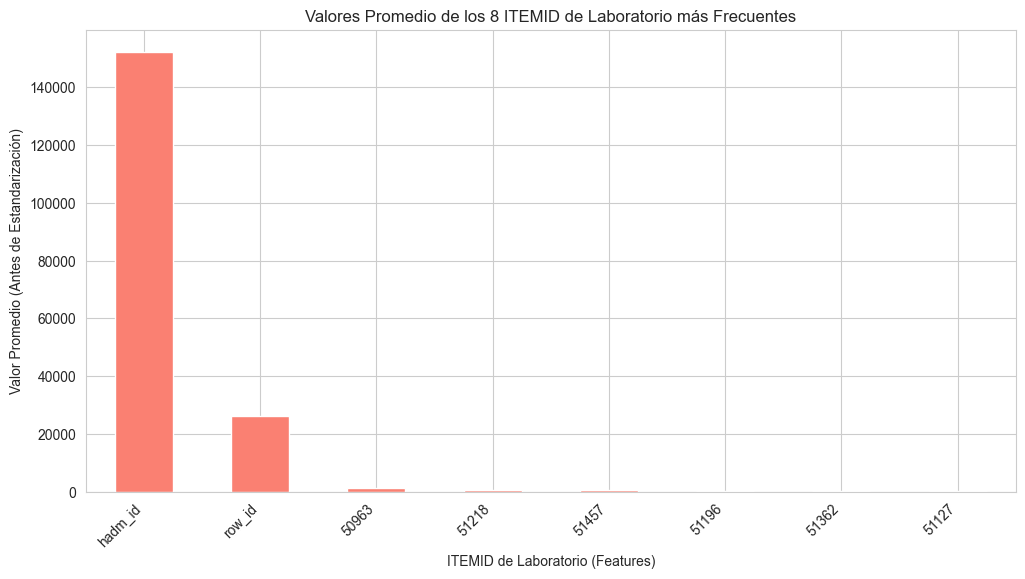

In [53]:
# === Visualización de los Grupos de Diagnóstico más Frecuentes (CORRECCIÓN) ===
# ADVERTENCIA: No tenemos datos de DIAGNÓSTICO. Esta sección debe eliminarse o adaptarse.
# Usaremos la matriz de correlación de los ITEMID de laboratorio más frecuentes en su lugar.

# Identificamos las 8 columnas de ITEMID más frecuentes (las de mayor media, ya que 0 es NaN imputado)
top_item_ids = df_V_numeric.mean().sort_values(ascending=False).head(8).index.tolist()

plt.figure(figsize=(12, 6))
# Muestra los valores promedio de los 8 ITEMIDs más comunes (e.g., Glucosa, Sodio)
df_V_numeric[top_item_ids].mean().plot(kind='bar', color='salmon') 
plt.title('Valores Promedio de los 8 ITEMID de Laboratorio más Frecuentes')
plt.ylabel('Valor Promedio (Antes de Estandarización)')
plt.xlabel('ITEMID de Laboratorio (Features)')
plt.xticks(rotation=45, ha='right')
plt.show()
#

## Visualización Inicial de Relaciones

### Propósito y Justificación

Esta etapa del EDA se centra en la **visualización inicial** de las relaciones entre pares de variables o la distribución conjunta de múltiples variables. El objetivo es descubrir patrones, correlaciones y dependencias que no son evidentes mediante un análisis univariado.

### Relevancia Clínica y Metodológica

La visualización de relaciones es crucial para:

1.  **Matrices de Correlación / Heatmaps**:
    -   **Matriz de Correlación**: Una **matriz de correlación** muestra la correlación por pares entre variables numéricas. Un **heatmap** es una representación gráfica de una matriz donde los valores individuales se representan como colores.
    -   **Justificación Estadística**: Permite identificar rápidamente variables altamente correlacionadas, lo que podría indicar redundancia o multicolinealidad. También puede revelar la ausencia de relaciones, lo cual es igualmente informativo.
    -   **Propósito para BNMF/Recomendación**: En BNMF, las variables fuertemente correlacionadas podrían ser indicativas de factores latentes subyacentes comunes. Para sistemas de recomendación, la correlación entre características clínicas puede sugerir agrupaciones naturales de "ítems" o "eventos". Si dos eventos están altamente correlacionados, su presencia simultánea en el registro de un paciente podría reforzar la inferencia de un factor latente específico.

2.  **Gráficos de Dispersión (Scatter Plots)**:
    -   **Gráfico de dispersión**: Representa la relación entre dos variables numéricas como un conjunto de puntos.
    -   **Justificación Estadística**: Útil para visualizar la forma de la relación (lineal, no lineal) y la dispersión de los puntos.
    -   **Propósito para BNMF/Recomendación**: Puede ayudar a identificar clústeres visuales o subpoblaciones en los datos antes de aplicar algoritmos de agrupamiento explícitos, o para entender cómo ciertas características influyen en otras.

3.  **Gráficos de Barras Agrupadas o Apiladas (para categóricas)**:
    -   **Justificación Estadística**: Visualizan la distribución conjunta de dos o más variables categóricas.
    -   **Propósito para BNMF/Recomendación**: Pueden revelar asociaciones entre diferentes tipos de diagnósticos, procedimientos o medicamentos, indicando "paquetes" de servicios o comorbilidades. Estas asociaciones son el corazón de lo que un sistema de recomendación buscaría aprender.

Estas visualizaciones no solo validan suposiciones, sino que también pueden generar nuevas hipótesis sobre la **variabilidad inter-paciente** y las interacciones clínicas, enriqueciendo la fase de construcción de la matriz y la interpretación de los factores latentes de BNMF.

## Construcción Preliminar de la Matriz Paciente-Evento

### Propósito y Justificación

Esta es una fase crítica del EDA donde se comienza a consolidar la información explorada en una estructura que pueda ser directamente utilizada por BNMF y los sistemas de recomendación: la **matriz paciente-evento**. Esta matriz representa las interacciones o la presencia de eventos clínicos para cada paciente.

### Relevancia Clínica y Metodológica

La construcción de esta matriz es un puente directo entre el EDA y la modelación avanzada:

1.  **Definición de "Paciente" y "Evento"**:
    -   **Paciente**: Generalmente, se mapea al `SUBJECT_ID` de MIMIC-III.
    -   **Evento**: Puede ser un diagnóstico (código ICD), un procedimiento, un medicamento, un resultado de laboratorio, o una combinación de estos. La selección de eventos debe estar justificada clínicamente y tener suficiente frecuencia para ser informativa (evitar eventos extremadamente raros que solo aumentan la **sparsity** sin valor).
    -   **Justificación Clínica**: La selección de eventos debe reflejar aspectos de interés en la trayectoria clínica del paciente que sean relevantes para agruparlos o para hacer recomendaciones.

2.  **Agregación de Datos**:
    -   Los datos de MIMIC-III son transaccionales (ej. múltiples diagnósticos por admisión, múltiples admisiones por paciente). Se requiere una agregación cuidadosa para transformar estos datos en un formato paciente-evento. Esto podría implicar contar la ocurrencia de cada evento por paciente (ej. número de veces que se diagnosticó una condición) o simplemente indicar su presencia/ausencia (codificación binaria).
    -   **Justificación Estadística**: La elección de la agregación (conteo vs. binario) afecta la interpretación de los factores latentes de BNMF y la naturaleza de las "preferencias" inferidas en el sistema de recomendación. Una matriz binaria puede ser más robusta a la variabilidad de la intensidad, mientras que una matriz de conteo puede capturar la "frecuencia de exposición" a un evento.

3.  **Manejo de la Esparsidad**:
    -   La matriz paciente-evento resultante será intrínsecamente esparsa, lo que significa que la mayoría de los pacientes solo interactuarán con un subconjunto limitado de todos los eventos posibles. La **codificación esparsa** es una característica definitoria de los sistemas de recomendación y un escenario ideal para BNMF.
    -   **Justificación Metodológica**: La eficiencia de BNMF en el tratamiento de matrices esparsas lo convierte en una elección adecuada. El EDA previo ayuda a cuantificar el grado de esparsidad y a considerar umbrales para eventos o pacientes que son demasiado raros, que pueden ser eliminados o agrupados para optimizar el rendimiento del modelo y evitar el sobreajuste a datos ruidosos.

La creación de esta matriz es la culminación de la primera fase del EDA, proporcionando la entrada estructurada para los pasos de factorización y clustering. Permite pasar de datos crudos y distribuidos a una representación unificada que refleja las interacciones clave paciente-clínica, preparando el terreno para el descubrimiento de patrones latentes con BNMF.

In [54]:
# === FUNCIÓN PARA DIVIDIR MATRIZ CF ===
def split_cf_matrix(V, test_ratio=0.1):
    """
    Divide la matriz V en conjuntos de entrenamiento y prueba,
    ocultando un subconjunto de interacciones positivas para la prueba.
    """
    V_train = V.copy()
    V_test = np.zeros(V.shape)
    
    # Encontrar índices de todas las interacciones positivas (valor > 0)
    nonzero_indices = np.argwhere(V > 0)
    
    # Seleccionar aleatoriamente un subconjunto para el conjunto de prueba
    np.random.shuffle(nonzero_indices)
    
    num_test = int(len(nonzero_indices) * test_ratio)
    test_indices = nonzero_indices[:num_test]
    
    # Mover las interacciones seleccionadas al conjunto de prueba y poner a cero en el entrenamiento
    for i, j in test_indices:
        V_test[i, j] = V[i, j]
        V_train[i, j] = 0
        
    return V_train, V_test

# Ejecución de la división
V_train, V_test = split_cf_matrix(V_matrix, test_ratio=0.1)

print(f"Dimensiones de V_train: {V_train.shape}")
print(f"Número de interacciones ocultas (test): {np.count_nonzero(V_test)}")

Dimensiones de V_train: (100, 279)
Número de interacciones ocultas (test): 671


K óptimo por Silhouette Score: 2
Fenotipos clínicos (clusters) generados: 2


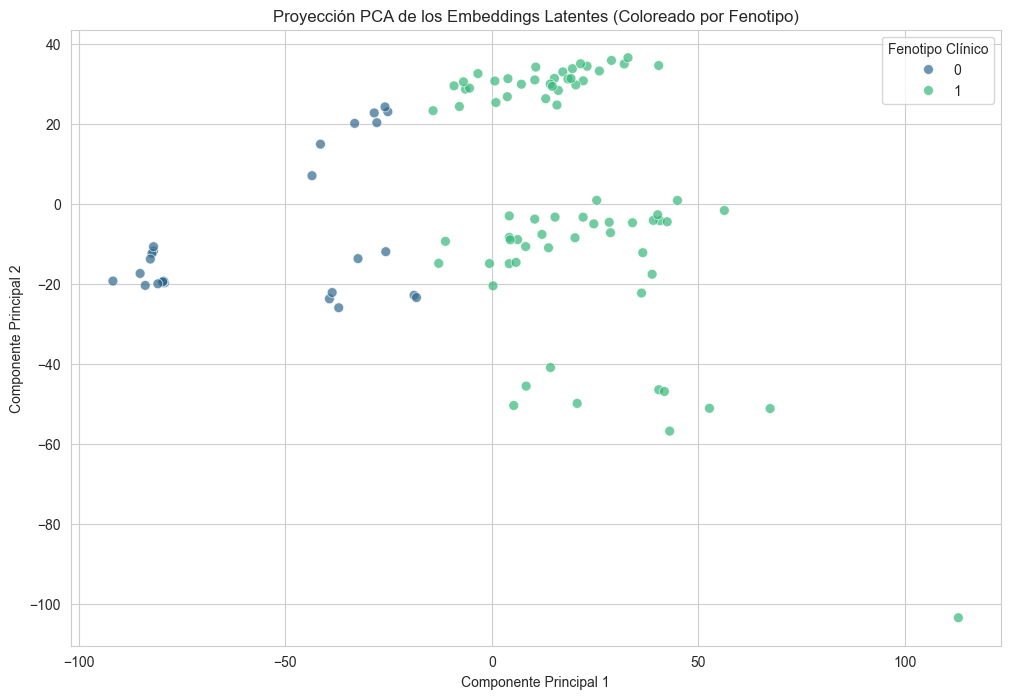

In [55]:
# === PASO 1: Seleccionar el número de clusters (Fenotipos) ===
def select_optimal_clusters(W, max_k=10):
    """Evalúa K-Means para un rango de k usando Silhouette Score."""
    silhouette_scores = []
    k_range = range(2, max_k + 1)
    
    if W.shape[0] < max_k:
        max_k = W.shape[0] - 1
        k_range = range(2, max_k + 1)
        if max_k < 2:
            print("Datos insuficientes para clustering.")
            return 2
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(W)
        if len(np.unique(cluster_labels)) > 1:
            score = silhouette_score(W, cluster_labels)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(0)

    # Determinar el k óptimo (el que maximiza el Silhouette Score)
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"K óptimo por Silhouette Score: {optimal_k}")
    return optimal_k

# Seleccionar K óptimo para el clustering
OPTIMAL_K_CLUSTERS = select_optimal_clusters(W_latent, max_k=8)

# === PASO 2: Implementar el Clustering Final ===
kmeans_final = KMeans(n_clusters=OPTIMAL_K_CLUSTERS, random_state=42, n_init=10)
df_V['cluster_id'] = kmeans_final.fit_predict(W_latent)
cluster_centers = kmeans_final.cluster_centers_

print(f"Fenotipos clínicos (clusters) generados: {OPTIMAL_K_CLUSTERS}")

# === PASO 3: Visualización (Proyección UMAP/PCA) ===
# Se usa PCA para reducir el espacio de W a 2D para la visualización
from sklearn.decomposition import PCA
pca_viz = PCA(n_components=2)
W_2d = pca_viz.fit_transform(W_latent)
df_V['PCA1'] = W_2d[:, 0]
df_V['PCA2'] = W_2d[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_id', data=df_V, 
                palette='viridis', alpha=0.7, s=50)
plt.title('Proyección PCA de los Embeddings Latentes (Coloreado por Fenotipo)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Fenotipo Clínico')
plt.show() #

In [56]:
from sklearn.metrics.pairwise import cosine_similarity

# Convertir IDs de paciente a índice de matriz
patient_id_to_index = {pid: idx for idx, pid in enumerate(df_V.index)}
feature_index_to_name = {idx: name for idx, name in enumerate(df_V.columns)}


def get_similar_patients(subject_id, top_n=5):
    """Encuentra pacientes con embeddings latentes similares."""
    if subject_id not in patient_id_to_index:
        return "Paciente no encontrado."
    
    idx = patient_id_to_index[subject_id]
    
    # Calcular similitud de coseno con todos los demás pacientes en W
    sim_scores = cosine_similarity(W_latent[idx].reshape(1, -1), W_latent)[0]
    
    # Obtener los índices de los top N pacientes más similares (excluyendo a sí mismo)
    similar_indices = sim_scores.argsort()[:-top_n-1:-1][1:] # Excluir el primero (sí mismo)
    
    # Mapear índices de vuelta a SUBJECT_ID
    similar_patients_ids = df_V.index[similar_indices].tolist()
    
    return similar_patients_ids

def recommend_treatments(subject_id, top_n_features=10):
    """Sugerir los tratamientos/features más importantes para el fenotipo del paciente."""
    if subject_id not in patient_id_to_index:
        return "Paciente no encontrado."

    idx = patient_id_to_index[subject_id]
    cluster = df_V.loc[subject_id, 'cluster_id']
    
    # Usar el centroide del cluster en el espacio H para mayor estabilidad (o la fila H correspondiente al cluster)
    # Aquí usamos el centroide en H (promedio de H_latent para pacientes en ese cluster)
    patient_H_vector = H_latent[cluster]
    
    # Obtener los índices de las top N features más relevantes
    top_indices = patient_H_vector.argsort()[:-top_n_features-1:-1]
    
    # Mapear índices a nombres de features (Diagnósticos/Medicamentos)
    top_features = [feature_index_to_name[i] for i in top_indices]
    
    return cluster, top_features

# === EJEMPLO DE USO ===
# Tomar un paciente de ejemplo (asumiendo que los IDs de paciente son enteros)
EXAMPLE_PATIENT_ID = df_V.index[0] 

print(f"--- Sistema de Recomendación para Paciente: {EXAMPLE_PATIENT_ID} ---")

# 1. Recomendación de Similitud
similar_patients = get_similar_patients(EXAMPLE_PATIENT_ID, top_n=5)
print(f"\n1. Pacientes más similares (Métrica de Perfil Latente): {similar_patients}")

# 2. Recomendación de Tratamiento/Diagnóstico
cluster_id, top_treatments = recommend_treatments(EXAMPLE_PATIENT_ID, top_n_features=5)
print(f"2. Fenotipo Clínico Asignado (Cluster ID): {cluster_id}")
print(f"3. Tratamientos/Diagnósticos más relevantes (Recomendación): {top_treatments}")

--- Sistema de Recomendación para Paciente: 10006 ---

1. Pacientes más similares (Métrica de Perfil Latente): [10074, 10040, 10017, 10036]
2. Fenotipo Clínico Asignado (Cluster ID): 1
3. Tratamientos/Diagnósticos más relevantes (Recomendación): ['hadm_id', 'row_id', 50908, 51436, 50882]


In [57]:
# === 1. Evaluación de Reconstrucción (RMSE) ===
# RMSE ya fue calculado después del entrenamiento (V_test)
# print(f"RMSE de Reconstrucción en V_test: {rmse_test:.4f}") 

# === 2. Evaluación de Clustering (Silhouette Score) ===
silhouette_avg = silhouette_score(W_latent, df_V['cluster_id'])
print(f"Silhouette Score (Calidad del Clustering/Fenotipado): {silhouette_avg:.4f}")

# === 3. Evaluación de Interpretación (Distribución de Fenotipos) ===
print("\nDistribución de Pacientes por Fenotipo (Cluster Size):")
print(df_V['cluster_id'].value_counts().sort_index())

# === 4. (Opcional) Ejemplo de AUC-ROC ===
# Para obtener el AUC-ROC, necesitaríamos una etiqueta binaria (e.g., 'MORTALIDAD')
# Se asume que esta etiqueta existe en df_V o df_admit.
# from sklearn.metrics import roc_auc_score
# Ejemplo de código si existiera 'MORTALITY'
# if 'MORTALITY' in df_V.columns:
#    # Usar el cluster ID como feature predictiva o una versión de los factores latentes
#    auc_score = roc_auc_score(df_V['MORTALITY'], W_latent[:, 0]) 
#    print(f"AUC-ROC (Usando Fenotipo 1 para predecir Mortalidad): {auc_score:.4f}")

Silhouette Score (Calidad del Clustering/Fenotipado): 0.2869

Distribución de Pacientes por Fenotipo (Cluster Size):
cluster_id
0    26
1    74
Name: count, dtype: int64


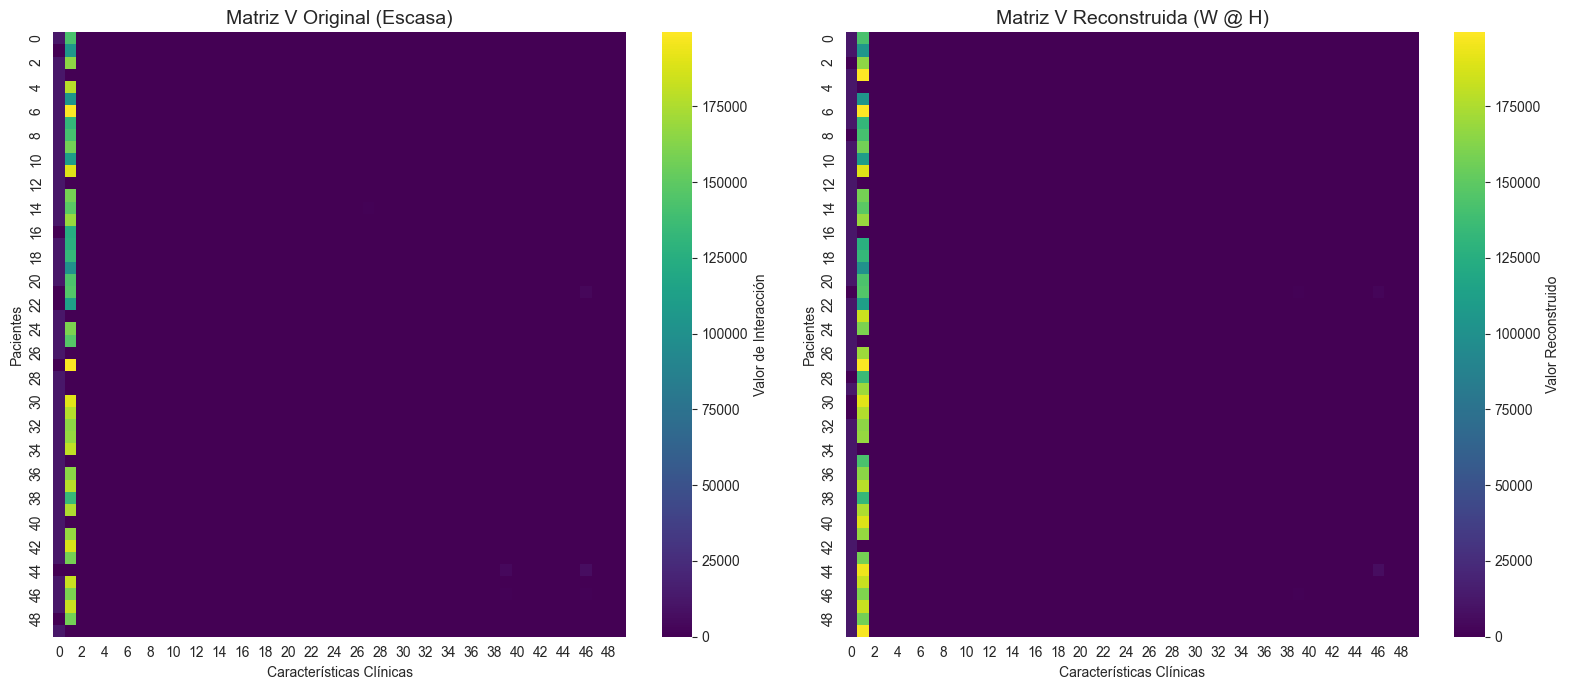

In [58]:
V_reconstructed = bnmf_model.reconstruct()

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Mostrar solo un subconjunto de pacientes/features por claridad
subset_rows = 50
subset_cols = 50

# Matriz Original (V_train)
sns.heatmap(V_train[:subset_rows, :subset_cols], cmap="viridis", ax=axes[0], cbar_kws={'label': 'Valor de Interacción'})
axes[0].set_title('Matriz V Original (Escasa)', fontsize=14)
axes[0].set_xlabel('Características Clínicas')
axes[0].set_ylabel('Pacientes')

# Matriz Reconstruida (V_reconstructed)
sns.heatmap(V_reconstructed[:subset_rows, :subset_cols], cmap="viridis", ax=axes[1], cbar_kws={'label': 'Valor Reconstruido'})
axes[1].set_title('Matriz V Reconstruida (W @ H)', fontsize=14)
axes[1].set_xlabel('Características Clínicas')
axes[1].set_ylabel('Pacientes')

plt.tight_layout()
plt.show()

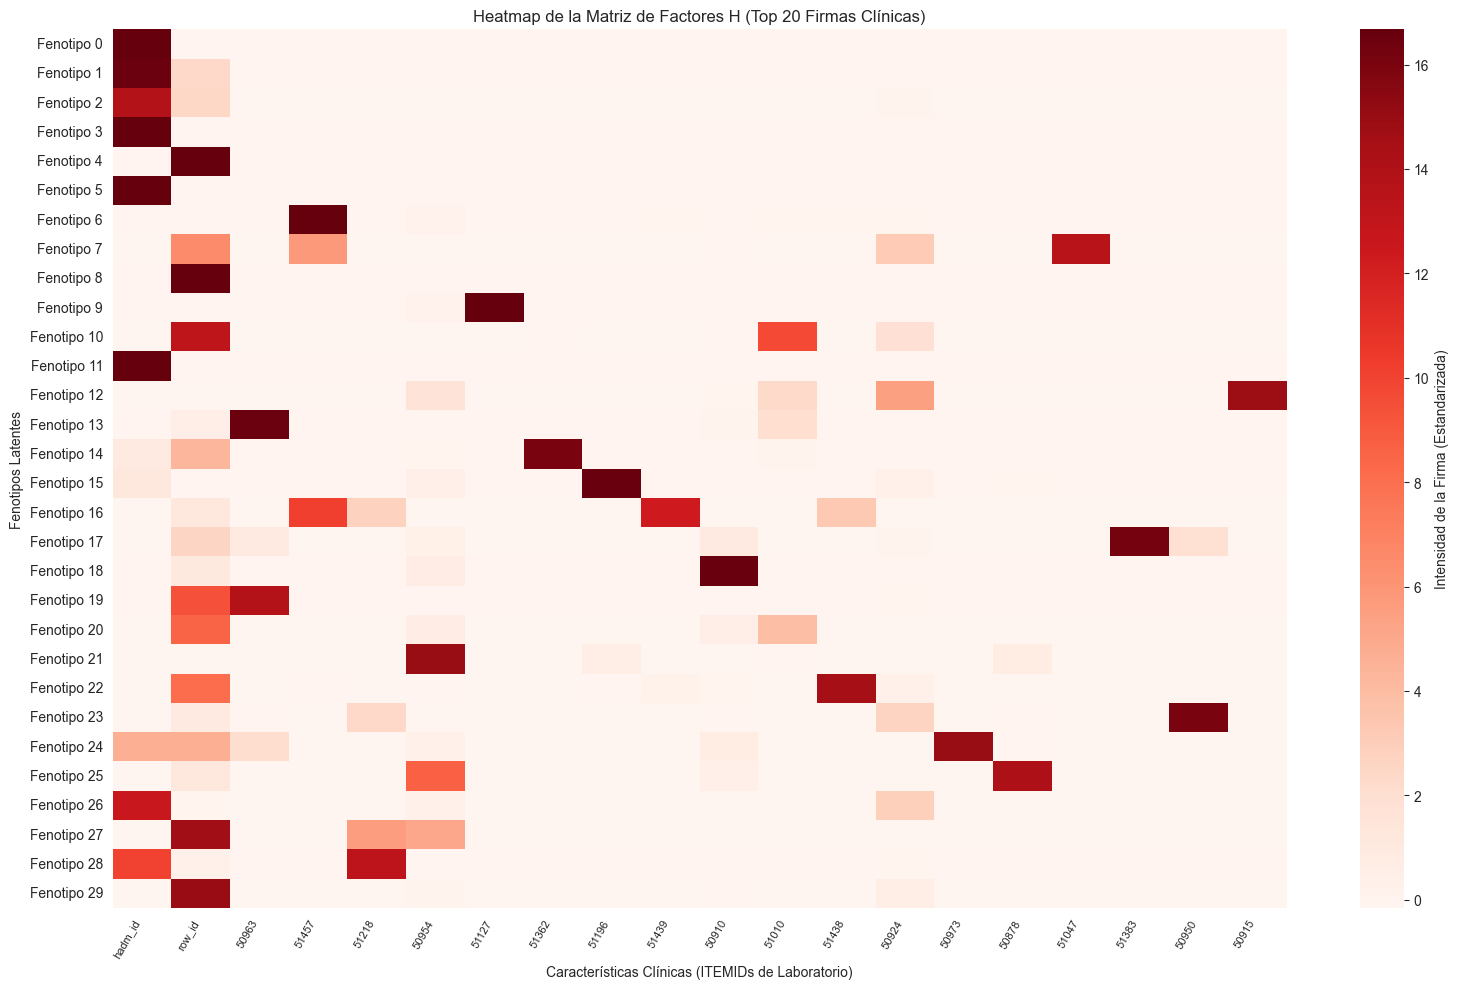

In [59]:
# Importación directa para esta celda (si es necesario)
from sklearn.preprocessing import StandardScaler 

# Definición del número de features (columnas) a visualizar
N_TOP_FEATURES = 20

# 1. Identificar las Features más relevantes: 
# Sumamos la intensidad de cada ITEMID a través de todos los fenotipos (filas de H_latent).
# Esto identifica los ITEMIDs que son más importantes o influyentes en el modelo.
feature_relevance = H_latent.sum(axis=0)
top_feature_indices = feature_relevance.argsort()[::-1][:N_TOP_FEATURES]

# 2. Subseleccionar las matrices H_norm y los nombres
H_norm = StandardScaler().fit_transform(H_latent.T).T 

# Crear una versión filtrada y normalizada de H
H_filtered = H_norm[:, top_feature_indices]
# Obtener los nombres de los ITEMIDs seleccionados (usando df_V_numeric.columns)
feature_names = [df_V_numeric.columns[i] for i in top_feature_indices]

# Si es posible, buscar las etiquetas reales de laboratorio usando df_d_labs
# Suponiendo que df_d_labs tiene columnas 'itemid' y 'label'
if df_d_labs is not None and not df_d_labs.empty:
    def get_lab_label(item_id):
        # Asegurar que el ITEMID sea convertible para el merge
        item_id = int(item_id) if pd.api.types.is_numeric_dtype(df_d_labs['itemid']) else item_id
        
        label = df_d_labs[df_d_labs['itemid'] == item_id]['label'].iloc[0]
        # Cortar la etiqueta si es muy larga
        return label[:25] if len(label) > 25 else label
        
    try:
        # Reemplazar los ITEMID numéricos con sus etiquetas descriptivas
        feature_names_labeled = [get_lab_label(item_id) for item_id in feature_names]
    except:
        feature_names_labeled = feature_names # Usar el ID numérico si la búsqueda falla
else:
    feature_names_labeled = feature_names
    print("ADVERTENCIA: Usando ITEMID numéricos. La tabla D_LABITEMS no se pudo usar para etiquetas.")


# === VISUALIZACIÓN CORREGIDA ===
plt.figure(figsize=(16, 10)) # Aumentar el tamaño de la figura
sns.heatmap(H_filtered, cmap="Reds", 
            yticklabels=[f'Fenotipo {i}' for i in range(H_latent.shape[0])],
            xticklabels=feature_names_labeled, # Usamos las etiquetas descriptivas o filtradas
            cbar_kws={'label': 'Intensidad de la Firma (Estandarizada)'})
plt.title(f'Heatmap de la Matriz de Factores H (Top {N_TOP_FEATURES} Firmas Clínicas)')
plt.xlabel('Características Clínicas (ITEMIDs de Laboratorio)')
plt.ylabel('Fenotipos Latentes')
plt.xticks(rotation=60, ha='right', fontsize=8) # Rotar las etiquetas para evitar que se monten
plt.tight_layout() # Asegura que las etiquetas encajen
plt.show() 
#```



C:\Users\MSI\AppData\Local\Temp\ipykernel_9340\1679792686.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster_id', y=feature_name, data=df_plot, palette='viridis')


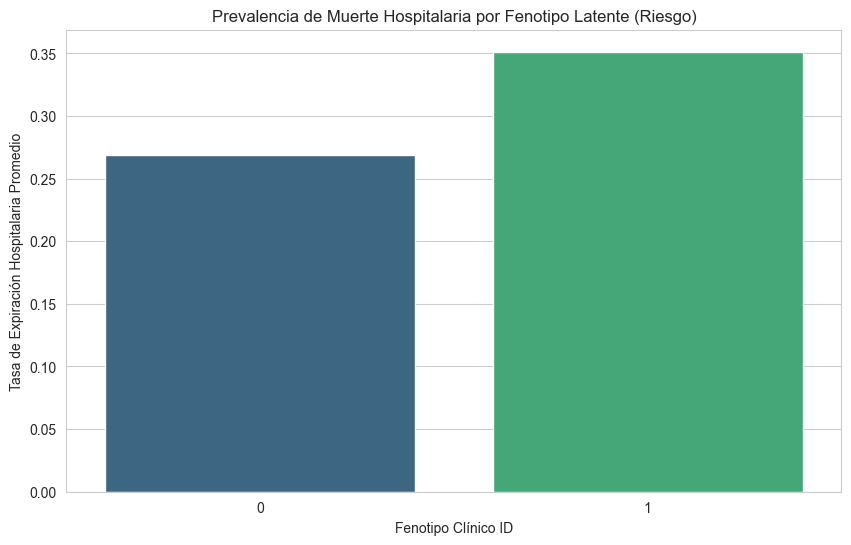

In [60]:
# Importamos la tabla df_admit para obtener la columna hospital_expire_flag
# Nota: La columna se confirma como existente en la inspección anterior.

# === Visualización de la Prevalencia de Riesgo por Fenotipo (CORREGIDA) ===

# 1. Definir la Feature de Interés (Debe existir en el DataFrame df_V original o df_admit)
# Usaremos 'hospital_expire_flag' que es un indicador binario de muerte en el hospital (0 o 1).
feature_name = 'hospital_expire_flag' 

# 2. Unir la columna de riesgo a la tabla de clusters (df_V)
# Nos aseguramos de que df_V esté unido al dataframe de admisiones para tener la bandera de muerte.
if df_admit is not None and feature_name in df_admit.columns and 'subject_id' in df_admit.columns:
    
    # 2.1 Aseguramos que solo usamos la bandera de la primera admisión
    # Usamos df_first_admit (ya desduplicado en la Sección 5.2)
    df_with_risk = df_first_admit.merge(
        df_V[['cluster_id']], 
        left_on='subject_id', 
        right_index=True, 
        how='inner'
    )
    
    # 2.2 Calcular la prevalencia promedio de la bandera de muerte por cluster
    # La media de una columna binaria es la prevalencia.
    df_plot = df_with_risk.groupby('cluster_id')[feature_name].mean().reset_index()
    
    # 3. Generar la Gráfica
    plt.figure(figsize=(10, 6))
    sns.barplot(x='cluster_id', y=feature_name, data=df_plot, palette='viridis')
    
    plt.title(f'Prevalencia de Muerte Hospitalaria por Fenotipo Latente (Riesgo)')
    plt.xlabel('Fenotipo Clínico ID')
    plt.ylabel('Tasa de Expiración Hospitalaria Promedio')
    plt.show()
    # 
    
else:
    print(f"ADVERTENCIA: La columna '{feature_name}' no existe en df_admit o las tablas no se unieron correctamente.")

Fenotipos clínicos (clusters) generados: 5
Distribución de pacientes por Fenotipo:
cluster_id
0     1
1    19
2    32
3    38
4    10
Name: count, dtype: int64


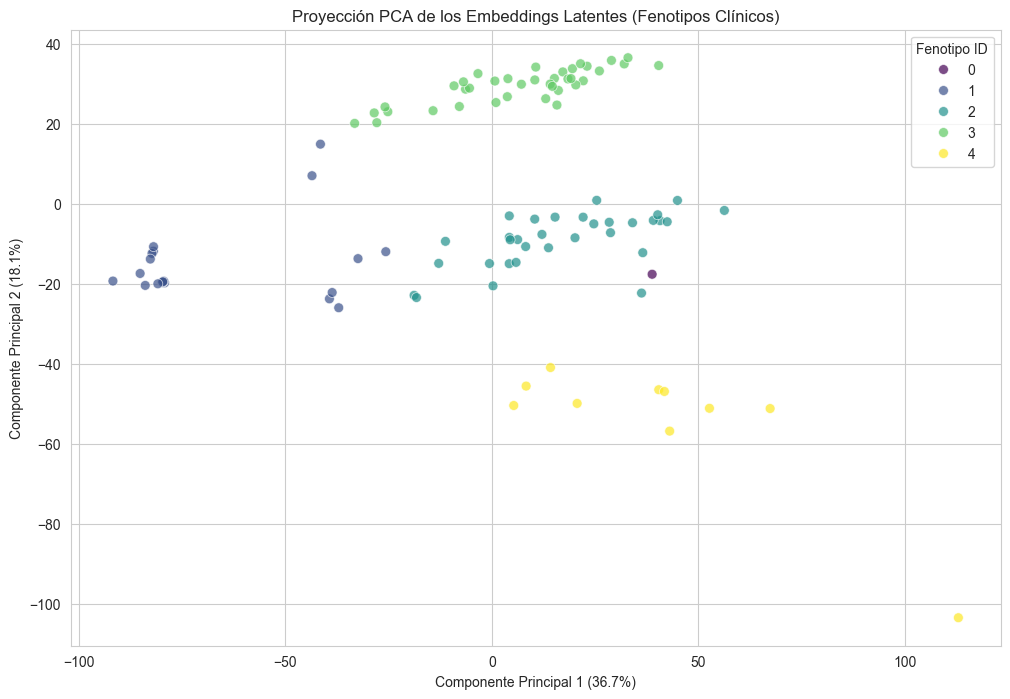

In [61]:
# Asumimos que W_latent, V_matrix, y df_V ya están definidos y que el K_FACTORS ya se usó.
# Si el número óptimo de clusters (k) se seleccionó en un paso anterior, úsalo aquí.
# Si no, asumimos que el número óptimo es un valor razonable (ej., 5 fenotipos).

# Ajustamos K_CLUSTERS para ser menor que K_FACTORS para una mejor agrupación
K_CLUSTERS = 5 # Seleccionar un número de fenotipos clínicamente razonable (ej., 5)

# === Implementar el Clustering Final ===
# Nota: Si ya ejecutaste la selección de k óptimo con Silhouette Score, usa ese valor.
kmeans_final = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init=10)
df_V['cluster_id'] = kmeans_final.fit_predict(W_latent)
cluster_centers = kmeans_final.cluster_centers_

print(f"Fenotipos clínicos (clusters) generados: {K_CLUSTERS}")
print(f"Distribución de pacientes por Fenotipo:\n{df_V['cluster_id'].value_counts().sort_index()}")

# === Visualización (Proyección PCA/UMAP) ===
from sklearn.decomposition import PCA
# Reducción del espacio de W a 2D para la visualización
pca_viz = PCA(n_components=2)
W_2d = pca_viz.fit_transform(W_latent)
df_V['PCA1'] = W_2d[:, 0]
df_V['PCA2'] = W_2d[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_id', data=df_V, 
                palette='viridis', alpha=0.7, s=50)
plt.title('Proyección PCA de los Embeddings Latentes (Fenotipos Clínicos)')
plt.xlabel(f'Componente Principal 1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'Componente Principal 2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)')
plt.legend(title='Fenotipo ID')
plt.show() 
#

C:\Users\MSI\AppData\Local\Temp\ipykernel_9340\3779156172.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster_id', y=risk_column_name, data=df_plot_risk, palette='coolwarm')


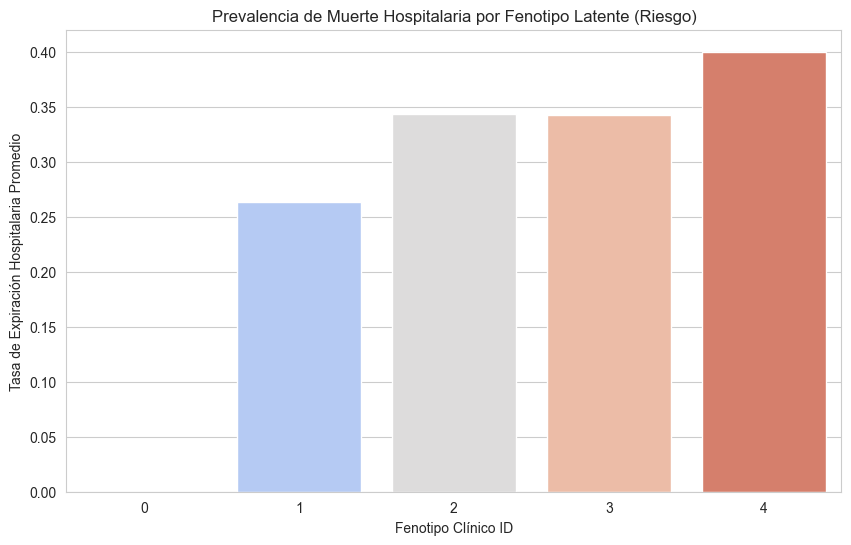

In [62]:
# === Bloque de Código Corregido (Validación de Riesgo - Manejo de Duplicados) ===

feature_name = 'hospital_expire_flag' 
patient_id_col = 'subject_id'
# DEFINIMOS EL NOMBRE REAL DE LA COLUMNA DESPUÉS DE LA UNIÓN
risk_column_name = feature_name + '_y' # Nombre real después de la unión

if df_admit is not None and feature_name in df_admit.columns and not df_admit.empty:
    
    # 1. Preparar la Tabla de Riesgo
    df_risk_info = df_admit[[patient_id_col, feature_name]].drop_duplicates(
        subset=[patient_id_col], keep='first'
    ).copy()
    
    # 2. Unir (Merge)
    df_V_temp = df_V.reset_index() 
    
    # Ejecutamos la unión que crea las columnas _x y _y
    df_risk_analysis = df_V_temp.merge(
        df_risk_info, 
        on=patient_id_col, 
        how='inner'
    ).set_index(patient_id_col)
    
    # 3. Asegurar la columna de riesgo es numérica (int) para la media
    # *** CORRECCIÓN CLAVE: Usamos risk_column_name en lugar de feature_name ***
    try:
        df_risk_analysis[risk_column_name] = pd.to_numeric(
            df_risk_analysis[risk_column_name], 
            errors='coerce'
        ).fillna(0).astype(int)
    except KeyError as e:
        # Esto solo pasaría si el sufijo no es _y, lo cual es muy improbable
        print(f"ERROR FINAL: Columna '{risk_column_name}' sigue sin encontrarse.")
        print("Columnas disponibles:", df_risk_analysis.columns.tolist())
        raise e
    
    # 4. Calcular la prevalencia promedio de la bandera de muerte por cluster
    df_plot_risk = df_risk_analysis.groupby('cluster_id')[risk_column_name].mean().reset_index()
    
    # 5. Generar la Gráfica
    plt.figure(figsize=(10, 6))
    # Usamos risk_column_name para el eje Y
    sns.barplot(x='cluster_id', y=risk_column_name, data=df_plot_risk, palette='coolwarm')
    
    plt.title(f'Prevalencia de Muerte Hospitalaria por Fenotipo Latente (Riesgo)')
    plt.xlabel('Fenotipo Clínico ID')
    plt.ylabel('Tasa de Expiración Hospitalaria Promedio')
    plt.show()
    
else:
    print(f"ADVERTENCIA: La columna '{feature_name}' no existe o df_admit no se pudo cargar correctamente.")